# 학습 결과

user1의 scene 1~3만 사용해서 학습

scene보다 user가 많기 때문에 데이터의 양이 확연히 줄어듬에도 불구하고 성능이 괜찮음.  
적은 데이터 특화됐기 때문인지는 모르겠다.

나머지 scene에 대해서도 잘 학습을 하면서 user에 대해서도 특화된다면 성능을 상당히 끌어올릴 수 있을 것으로 기대됨.  
--> curriculum learning

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = '1122-Scene3-CLSTM2-win48-GCNN-dyaw'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 48

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z',
                      'dyaw', 'dpitch', 'droll']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(18789, 18069)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 9]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([48, 9])

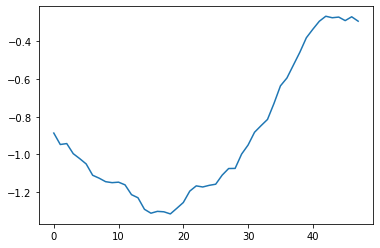

In [10]:
plt.plot(x[:, 2])

# 모델 생성

In [11]:
class CLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=24, num_layers=8, dropout=0.0, bidirectional=False):
        super(CLSTM, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(input_size, 12, 5, padding=2, groups=3),
            nn.BatchNorm1d(12),
            nn.LeakyReLU(),
            nn.Conv1d(12, 24, 5, padding=2),
            nn.BatchNorm1d(24),
        )

        self.rnn = nn.LSTM(input_size=24,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout,
                           bidirectional=bidirectional)

        out_channels = 2 * hidden_size if bidirectional else hidden_size
        self.fc = nn.Linear(out_channels, 3)

    def forward(self, x):
        x = x.transpose(1, 2)  # B, 48, 6 --> B, 6, 48
        x = self.conv_in(x)  # B, 64, 48
        x = x.transpose(1, 2)  # B, 48, 64

        outs, (hiddens, cells) = self.rnn(x)
        x = outs[:, -1, ...]
        x = self.fc(x)

        return x

In [12]:
model = CLSTM(input_size=9, hidden_size=64, num_layers=8, dropout=0.2, bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  19.002254
 - Pitch        :  10.124249
 - Roll         :   2.569284
 - RMS          :  12.519150
 - 99% Tile     :  43.648980
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  15.719317
 - Pitch        :   9.104604
 - Roll         :   2.600888
 - RMS          :  10.594894
 - 99% Tile     :  40.172875
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  11.490617
 - Pitch        :   9.022749
 - Roll         :   2.366055
 - RMS          :   8.544833
 - 99% Tile     :  34.252058
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  10.141831
 - Pitch        :   8.099226
 - Roll         :   2.373808
 - RMS          :   7.617724
 - 99% Tile     :  30.613068
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.361250
 - Pitch        :   7.548053
 - Roll         :   2.372429
 - RMS          :   6.646102
 - 99% Tile     :  27.708895
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.113002
 - Pitch        :   7.316483
 - Roll         :   2.381325
 - RMS          :   6.049695
 - 99% Tile     :  25.485057
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.946347
 - Pitch        :   7.265782
 - Roll         :   2.376834
 - RMS          :   5.591660
 - 99% Tile     :  24.236123
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.834596
 - Pitch        :   7.241570
 - Roll         :   2.351291
 - RMS          :   5.207118
 - 99% Tile     :  22.263449
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.534141
 - Pitch        :   7.063735
 - Roll         :   2.318901
 - RMS          :   5.027660
 - 99% Tile     :  21.658307
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.007027
 - Pitch        :   6.994201
 - Roll         :   2.280426
 - RMS          :   4.836509
 - 99% Tile     :  21.220210
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.569563
 - Pitch        :   6.675492
 - Roll         :   2.312258
 - RMS          :   4.857628
 - 99% Tile     :  21.085732
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.498244
 - Pitch        :   6.535889
 - Roll         :   2.314421
 - RMS          :   4.483752
 - 99% Tile     :  20.372387
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   3.202558
 - Pitch        :   6.557937
 - Roll         :   2.309987
 - RMS          :   4.419613
 - 99% Tile     :  20.897632
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.882291
 - Pitch        :   6.374380
 - Roll         :   2.342865
 - RMS          :   4.516412
 - 99% Tile     :  19.703163
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.576057
 - Pitch        :   6.163791
 - Roll         :   2.269490
 - RMS          :   4.317835
 - 99% Tile     :  19.645633
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.496723
 - Pitch        :   4.603714
 - Roll         :   2.331914
 - RMS          :   3.309866
 - 99% Tile     :  13.842837
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.781953
 - Pitch        :   2.743830
 - Roll         :   2.337486
 - RMS          :   2.321480
 - 99% Tile     :  11.537638
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.446559
 - Pitch        :   2.227601
 - Roll         :   2.311833
 - RMS          :   2.033004
 - 99% Tile     :  10.565972
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.606387
 - Pitch        :   2.169276
 - Roll         :   2.291606
 - RMS          :   2.044317
 - 99% Tile     :  10.034764
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.517878
 - Pitch        :   2.011808
 - Roll         :   2.336303
 - RMS          :   1.984073
 - 99% Tile     :   9.543526
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.790922
 - Pitch        :   1.548807
 - Roll         :   2.302336
 - RMS          :   1.906739
 - 99% Tile     :   8.963897
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.778863
 - Pitch        :   1.646347
 - Roll         :   2.292659
 - RMS          :   1.926231
 - 99% Tile     :   8.975207
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.432684
 - Pitch        :   2.080565
 - Roll         :   2.325780
 - RMS          :   1.982472
 - 99% Tile     :   8.463689
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.111312
 - Pitch        :   1.528598
 - Roll         :   2.267167
 - RMS          :   1.704081
 - 99% Tile     :   8.010101
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.259934
 - Pitch        :   1.518102
 - Roll         :   2.268840
 - RMS          :   1.735867
 - 99% Tile     :   7.857359
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.703636
 - Pitch        :   1.621863
 - Roll         :   2.233257
 - RMS          :   1.872632
 - 99% Tile     :   7.752753
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.204413
 - Pitch        :   1.329810
 - Roll         :   2.282933
 - RMS          :   1.676384
 - 99% Tile     :   7.737210
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.591470
 - Pitch        :   1.300805
 - Roll         :   2.220630
 - RMS          :   1.747004
 - 99% Tile     :   7.538873
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.378705
 - Pitch        :   1.287027
 - Roll         :   2.249484
 - RMS          :   1.694840
 - 99% Tile     :   7.465096
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.365273
 - Pitch        :   1.352744
 - Roll         :   2.277961
 - RMS          :   1.720755
 - 99% Tile     :   7.530400
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.657173
 - Pitch        :   1.307754
 - Roll         :   2.182560
 - RMS          :   1.753093
 - 99% Tile     :   7.332260
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.427109
 - Pitch        :   1.264367
 - Roll         :   2.210145
 - RMS          :   1.685231
 - 99% Tile     :   7.263119
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.144621
 - Pitch        :   1.261244
 - Roll         :   2.265999
 - RMS          :   1.636627
 - 99% Tile     :   7.344722
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.091095
 - Pitch        :   1.260880
 - Roll         :   2.200043
 - RMS          :   1.593790
 - 99% Tile     :   7.269341
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.167026
 - Pitch        :   1.298723
 - Roll         :   2.245974
 - RMS          :   1.642461
 - 99% Tile     :   7.301655
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.083602
 - Pitch        :   1.162107
 - Roll         :   2.245384
 - RMS          :   1.588126
 - 99% Tile     :   7.292524
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.221204
 - Pitch        :   1.268084
 - Roll         :   2.243835
 - RMS          :   1.646630
 - 99% Tile     :   7.154564
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.294401
 - Pitch        :   2.889280
 - Roll         :   2.328242
 - RMS          :   2.268929
 - 99% Tile     :   7.667100
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.179878
 - Pitch        :   1.528750
 - Roll         :   2.246484
 - RMS          :   1.710349
 - 99% Tile     :   7.483693
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.155499
 - Pitch        :   1.253815
 - Roll         :   2.197853
 - RMS          :   1.606008
 - 99% Tile     :   7.170459
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.605199
 - Pitch        :   1.346126
 - Roll         :   2.224934
 - RMS          :   1.764374
 - 99% Tile     :   7.153285
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   1.194410
 - Pitch        :   1.382816
 - Roll         :   2.219354
 - RMS          :   1.659752
 - 99% Tile     :   7.204858
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.057048
 - Pitch        :   1.173635
 - Roll         :   2.203674
 - RMS          :   1.565349
 - 99% Tile     :   7.002887
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.053880
 - Pitch        :   1.173506
 - Roll         :   2.212348
 - RMS          :   1.568679
 - 99% Tile     :   7.189717
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.927684
 - Pitch        :   1.208914
 - Roll         :   2.203870
 - RMS          :   1.546945
 - 99% Tile     :   7.017092
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.982688
 - Pitch        :   1.139213
 - Roll         :   2.194893
 - RMS          :   1.536341
 - 99% Tile     :   7.049975
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.065936
 - Pitch        :   1.164727
 - Roll         :   2.179136
 - RMS          :   1.553645
 - 99% Tile     :   7.034373
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.889535
 - Pitch        :   1.170305
 - Roll         :   2.182871
 - RMS          :   1.519409
 - 99% Tile     :   7.001624
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.123350
 - Pitch        :   1.282048
 - Roll         :   2.200696
 - RMS          :   1.607133
 - 99% Tile     :   7.055526
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.023276
 - Pitch        :   1.251817
 - Roll         :   2.159334
 - RMS          :   1.557440
 - 99% Tile     :   6.885900
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.090053
 - Pitch        :   1.212435
 - Roll         :   2.140788
 - RMS          :   1.553618
 - 99% Tile     :   6.894355
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.291428
 - Pitch        :   1.264724
 - Roll         :   2.206343
 - RMS          :   1.646740
 - 99% Tile     :   7.175841
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.899490
 - Pitch        :   1.216334
 - Roll         :   2.161627
 - RMS          :   1.523284
 - 99% Tile     :   7.020808
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.991794
 - Pitch        :   1.330148
 - Roll         :   2.163329
 - RMS          :   1.574054
 - 99% Tile     :   7.109894
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.020718
 - Pitch        :   1.171387
 - Roll         :   2.141322
 - RMS          :   1.527446
 - 99% Tile     :   6.961443
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.333567
 - Pitch        :   1.253492
 - Roll         :   2.127383
 - RMS          :   1.620226
 - 99% Tile     :   6.964571
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.085344
 - Pitch        :   1.221237
 - Roll         :   2.104000
 - RMS          :   1.537987
 - 99% Tile     :   7.024172
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.428774
 - Pitch        :   1.190483
 - Roll         :   2.151594
 - RMS          :   1.641950
 - 99% Tile     :   7.047222
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.907923
 - Pitch        :   1.187924
 - Roll         :   2.100653
 - RMS          :   1.488649
 - 99% Tile     :   6.965832
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.930313
 - Pitch        :   1.176073
 - Roll         :   2.093318
 - RMS          :   1.486676
 - 99% Tile     :   7.049808
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.938180
 - Pitch        :   1.174301
 - Roll         :   2.059370
 - RMS          :   1.471979
 - 99% Tile     :   6.834674
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.992979
 - Pitch        :   1.187063
 - Roll         :   2.023865
 - RMS          :   1.470959
 - 99% Tile     :   6.868501
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.916010
 - Pitch        :   1.160287
 - Roll         :   2.011371
 - RMS          :   1.441175
 - 99% Tile     :   6.922438
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.062569
 - Pitch        :   1.220168
 - Roll         :   1.984685
 - RMS          :   1.478382
 - 99% Tile     :   6.793959
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.975931
 - Pitch        :   1.178856
 - Roll         :   1.943383
 - RMS          :   1.428155
 - 99% Tile     :   6.729141
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.960551
 - Pitch        :   1.196572
 - Roll         :   1.889849
 - RMS          :   1.405462
 - 99% Tile     :   6.736533
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.053375
 - Pitch        :   1.211302
 - Roll         :   1.875255
 - RMS          :   1.425182
 - 99% Tile     :   6.592884
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0067.npy


[0069/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.895944
 - Pitch        :   1.192246
 - Roll         :   1.808711
 - RMS          :   1.353465
 - 99% Tile     :   6.648085
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0068.npy


[0070/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.915379
 - Pitch        :   1.184864
 - Roll         :   1.730719
 - RMS          :   1.321263
 - 99% Tile     :   6.472971
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0069.npy


[0071/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.990177
 - Pitch        :   1.144348
 - Roll         :   1.703450
 - RMS          :   1.315513
 - 99% Tile     :   6.430294
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0070.npy


[0072/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.989095
 - Pitch        :   1.155390
 - Roll         :   1.643253
 - RMS          :   1.292738
 - 99% Tile     :   6.403881
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0071.npy


[0073/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.215258
 - Pitch        :   1.249579
 - Roll         :   1.598142
 - RMS          :   1.365327
 - 99% Tile     :   6.350702
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0072.npy


[0074/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.984243
 - Pitch        :   1.179344
 - Roll         :   1.510996
 - RMS          :   1.244012
 - 99% Tile     :   6.127214
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0073.npy


[0075/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.892281
 - Pitch        :   1.259560
 - Roll         :   1.448584
 - RMS          :   1.222164
 - 99% Tile     :   6.081152
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0074.npy


[0076/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.898354
 - Pitch        :   1.267596
 - Roll         :   1.391735
 - RMS          :   1.204265
 - 99% Tile     :   6.005932
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0075.npy


[0077/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.898731
 - Pitch        :   1.113669
 - Roll         :   1.303077
 - RMS          :   1.117435
 - 99% Tile     :   5.767952
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0076.npy


[0078/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.047822
 - Pitch        :   1.164501
 - Roll         :   1.251361
 - RMS          :   1.157569
 - 99% Tile     :   5.888391
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0077.npy


[0079/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.881263
 - Pitch        :   1.092564
 - Roll         :   1.180205
 - RMS          :   1.058805
 - 99% Tile     :   5.697746
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0078.npy


[0080/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.893820
 - Pitch        :   1.104690
 - Roll         :   1.154909
 - RMS          :   1.057209
 - 99% Tile     :   5.748619
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0079.npy


[0081/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.178577
 - Pitch        :   1.081130
 - Roll         :   1.116773
 - RMS          :   1.126213
 - 99% Tile     :   5.553913
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0080.npy


[0082/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.994270
 - Pitch        :   1.062920
 - Roll         :   1.104372
 - RMS          :   1.054832
 - 99% Tile     :   5.740980
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0081.npy


[0083/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.930562
 - Pitch        :   1.099572
 - Roll         :   1.064149
 - RMS          :   1.033992
 - 99% Tile     :   5.622242
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0082.npy


[0084/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.856463
 - Pitch        :   1.163530
 - Roll         :   1.050359
 - RMS          :   1.031275
 - 99% Tile     :   5.634069
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0083.npy


[0085/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.978900
 - Pitch        :   1.040529
 - Roll         :   1.032397
 - RMS          :   1.017643
 - 99% Tile     :   5.489738
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0084.npy


[0086/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.037558
 - Pitch        :   1.111027
 - Roll         :   0.992265
 - RMS          :   1.048093
 - 99% Tile     :   5.550692
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0085.npy


[0087/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.996404
 - Pitch        :   1.103725
 - Roll         :   1.029760
 - RMS          :   1.044260
 - 99% Tile     :   5.602274
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0086.npy


[0088/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.870732
 - Pitch        :   0.992896
 - Roll         :   0.965465
 - RMS          :   0.944482
 - 99% Tile     :   5.497956
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0087.npy


[0089/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.841785
 - Pitch        :   1.135969
 - Roll         :   0.957437
 - RMS          :   0.985852
 - 99% Tile     :   5.505611
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0088.npy


[0090/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.844376
 - Pitch        :   1.424653
 - Roll         :   0.971689
 - RMS          :   1.108571
 - 99% Tile     :   5.622076
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0089.npy


[0091/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.850751
 - Pitch        :   1.025583
 - Roll         :   0.979028
 - RMS          :   0.954654
 - 99% Tile     :   5.432878
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0090.npy


[0092/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.865672
 - Pitch        :   1.157564
 - Roll         :   0.915056
 - RMS          :   0.987703
 - 99% Tile     :   5.477655
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0091.npy


[0093/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.922589
 - Pitch        :   0.999916
 - Roll         :   0.880738
 - RMS          :   0.935718
 - 99% Tile     :   5.377146
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0092.npy


[0094/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.873291
 - Pitch        :   1.000402
 - Roll         :   0.887772
 - RMS          :   0.922240
 - 99% Tile     :   5.460424
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0093.npy


[0095/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.887883
 - Pitch        :   1.079487
 - Roll         :   0.886255
 - RMS          :   0.955524
 - 99% Tile     :   5.362318
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0094.npy


[0096/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.902608
 - Pitch        :   0.955981
 - Roll         :   0.866955
 - RMS          :   0.909251
 - 99% Tile     :   5.310884
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0095.npy


[0097/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.849380
 - Pitch        :   0.967179
 - Roll         :   0.887441
 - RMS          :   0.902669
 - 99% Tile     :   5.280553
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0096.npy


[0098/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.951931
 - Pitch        :   0.968555
 - Roll         :   0.830936
 - RMS          :   0.919189
 - 99% Tile     :   5.295491
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0097.npy


[0099/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.868824
 - Pitch        :   1.078589
 - Roll         :   0.809443
 - RMS          :   0.926176
 - 99% Tile     :   5.419207
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0098.npy


[0100/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.955035
 - Pitch        :   1.055457
 - Roll         :   0.834763
 - RMS          :   0.952700
 - 99% Tile     :   5.414097
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0099.npy


[0100/0100] Validation: 100%|██████████████████████| 71/71 [00:04<00:00, 15.98it/s, val_loss 2.6332]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.184760
 - Pitch        :   1.004323
 - Roll         :   0.847792
 - RMS          :   1.021612
 - 99% Tile     :   5.490884
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-GCNN-dyaw/sample/0100.npy
